In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import numpy as np
import tqdm

In [23]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def plot_one_min_data(stn_id, v, event_time, ax, ls="-", color="tab:blue", marker=None, pad=2):
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)) < dt.timedelta(seconds=3600):
                if (stn_id == "090035") & (event_time.year==2020) & (event_time.month==1) & (event_time.day==31):
                    time = df.sort_values("wg").index[-2]
                else:
                    time = df.index[np.argmax(df.wg)]
                    
                rolling = pd.to_numeric(df["wg"],errors="coerce").rolling("4H",center=True,closed="both").mean()
                df["rolling4"] = rolling
                df["wgr_4"] = pd.to_numeric(df["wg"],errors="coerce") / df["rolling4"]                     
                    
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))               

                if v == "wg":
                    ax.set_ylim([0,40])
                    lab="Wind gust (m/s)"
                elif v == "wd":
                    ax.set_ylim([0,360])
                    lab="Direction from North (degrees)"
                elif v == "mslp":
                    ax.set_ylim([998,1020])   
                    lab="Mean sea-level pressure (hPa)"
                elif v == "dp":
                    ax.set_ylim([5,45])                     
                    lab="Dewpoint temperature (Celsius)"
                elif v == "t":
                    ax.set_ylim([5,45]) 
                    lab="Air temperature (Celsius)"                    
                elif v in ["p"]:
                    ax.set_ylim([0,40])                 
                    lab="Precipitation (mm)"
                elif v in ["wgr_4"]:
                    ax.set_ylim([0,5])  
                    ax.yaxis.tick_left()
                    lab="Peak-to-mean gust ratio"
                if v == "p":
                    df[v] = pd.to_numeric(df[v], errors="coerce").cumsum()                   
                else:
                    df[v] = pd.to_numeric(df[v], errors="coerce").interpolate()                         
                line = ax.plot(df.index.to_pydatetime(), df[v].values, ls=ls, color=color, marker=marker, label=lab)
                ax.tick_params(axis='y', colors=color, pad=pad, labelsize=14)
                ax.tick_params(axis='x', rotation=0, labelsize=14)    
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                ax.axvline(time, color="k", ls="--", lw=1)
                
                return line
        else:
                pass
   
def plot_driver(state, stn_id, t, rows, cols, num, title, legend=False, left_ticks=False, right_ticks=False):
    if (t == dt.datetime(2013,10,29,3,8)) | (t == dt.datetime(2017,12,19,8,50)):
        lightning1 = pd.DataFrame()
        lightning3 = pd.DataFrame()
    else:
        lightning1 = load_lightning((t+dt.timedelta(days=-1)).strftime("%Y%m%d"), stn_id, state)
        lightning3 = load_lightning((t+dt.timedelta(days=1)).strftime("%Y%m%d"), stn_id, state) 
    lightning2 = load_lightning((t+dt.timedelta(days=0)).strftime("%Y%m%d"), stn_id, state)
    lightning = pd.concat([lightning1, lightning2, lightning3], axis=0)
    lightning = lightning.loc[(lightning.index>=(t + dt.timedelta(seconds=-2*60*60))) & (lightning.index <= t + dt.timedelta(seconds=2*60*60)),"latlon"]    
    ax1=plt.subplot(rows,cols,num)
    ax2=ax1.twinx()
    ax3=ax1.twinx()    
    ax4=ax1.twinx()       
    line1=plot_one_min_data(stn_id, "wg", t, ax1,color="tab:red")
    # line2=plot_one_min_data(stn_id, "wd", t, ax2, color="tab:red", ls=":")
    line2=plot_one_min_data(stn_id, "p", t, ax2, color="tab:blue", ls="--", pad=20)    
    line3=ax3.plot(lightning, color="tab:purple", lw=0.5, label="Lightning strokes in 50 km radius (1 min.)")
    line4=plot_one_min_data(stn_id, "wgr_4", t, ax4, color="k", ls="-",pad=26)     
    ax4.axhline(2,ls=":",color="k")
    ax3.tick_params(axis='y', colors="tab:purple", pad=5, labelsize=14)
    ax3.set_ylim([-1,30])
    ax1.set_title(title, loc="left")
    ax1.xaxis.set_major_locator(mdates.HourLocator())
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(30))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.grid(which="both")
    if legend:
        plt.legend((line1[0], line4[0], line2[0], line3[0]), (line1[0].get_label(), line4[0].get_label() , line2[0].get_label(),line3[0].get_label()),
               loc=3, bbox_to_anchor=(-0.5,-0.85), ncol=4,fontsize="large")
        
    if not left_ticks:
        ax1.set_yticklabels("")
        ax4.set_yticklabels("")
    if not right_ticks:
        ax2.set_yticklabels("")        
        ax3.set_yticklabels("")   

    
def load_lightning(date, stn_no, state):

    try:
        lightning = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_raw/A"+date+".loc",header=None,
                               names=["date","time","lat","lon","1","2"])
    except:
        lightning = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_raw/AE"+date+".loc",header=None,
                               names=["date","time","lat","lon","1","2","3","4","5"])
    names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                    "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
    stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
            names=names, header=0)
    lightning["l_dist"] = latlon_dist(stn_df[stn_df.stn_no==int(stn_no)].lat.values[0], stn_df[stn_df.stn_no==int(stn_no)].lon.values[0],
        lightning["lat"], lightning["lon"])
    lightning["latlon"] = lightning["lat"].astype("str") + " " + lightning["lon"].astype("str")
    lightning["latlon"] = lightning.latlon.where(lightning.l_dist <= 50, np.nan)

    lightning["datetime"] = pd.DatetimeIndex(lightning["date"] + " " + lightning["time"])
    lightning = lightning.set_index(lightning["datetime"])    
    return lightning[["lat","lon","l_dist","latlon"]].resample("1min").nunique()    

In [3]:
details = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")
details["gust_time_utc"] = pd.DatetimeIndex(details.gust_time_utc)
details["rid"] = details.rid.astype(str)
details["stn_id"] = details.stn_id.astype(str).str.pad(width=6,side="left",fillchar="0")

details_list = []
for locs in [["Melbourne"],["Sydney"],["Oakey","Amberley"],["Woomera"]]:
    details_list.append(details[np.in1d(details.stn_name, locs)])

9it [01:58, 13.12s/it]
9it [02:04, 13.85s/it]
9it [03:34, 23.86s/it]
9it [02:37, 17.47s/it]


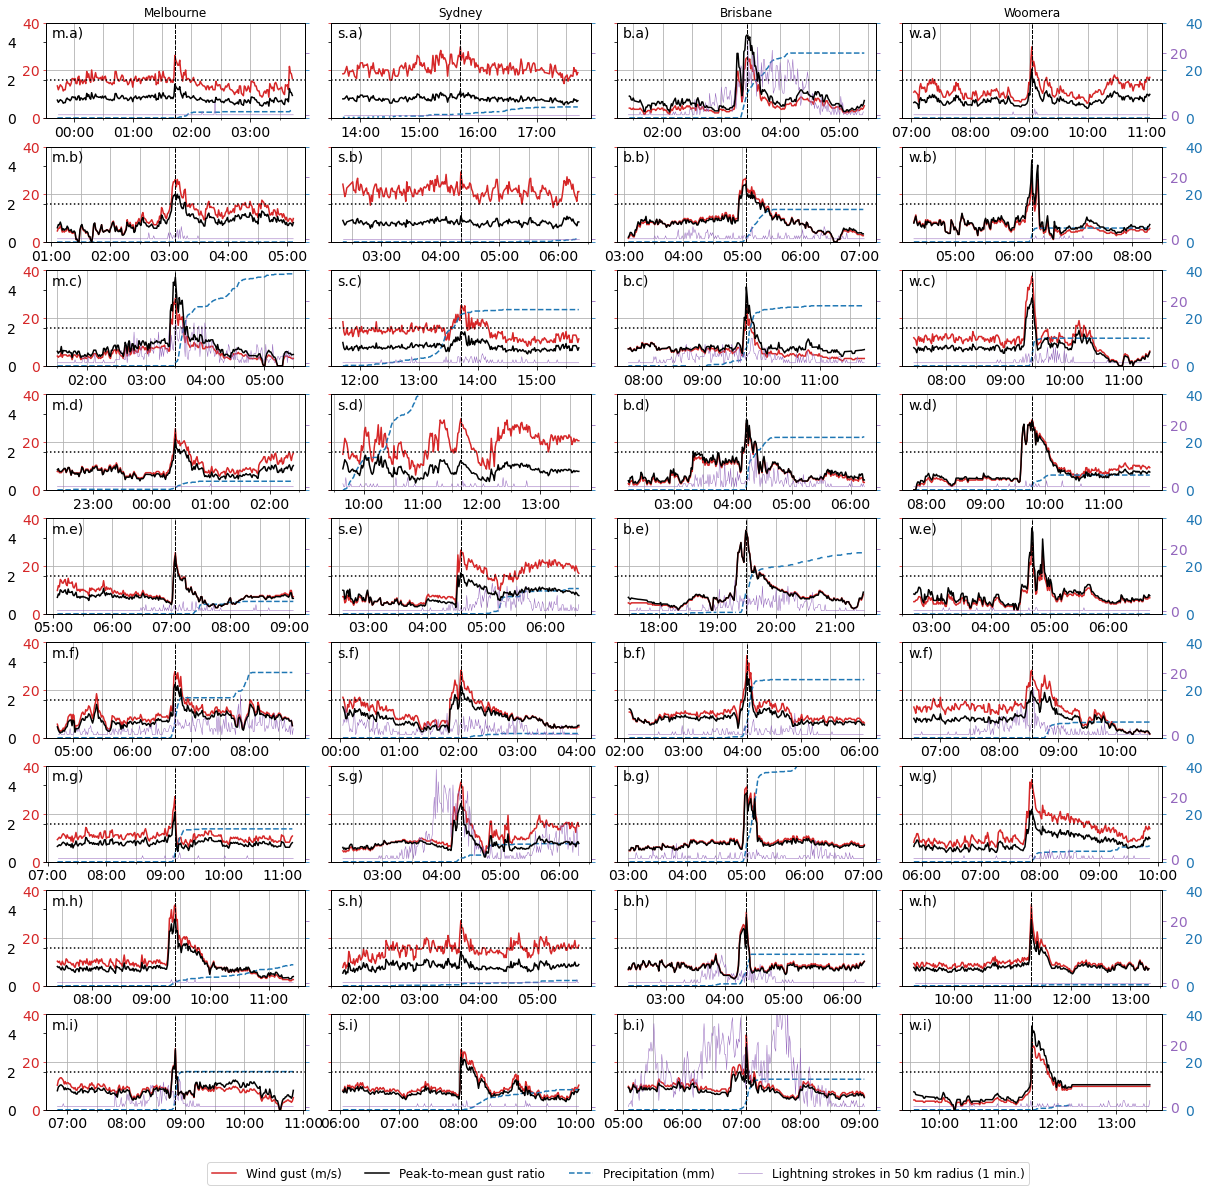

In [27]:
fig = plt.figure(figsize=[20,20])
letters = ["a","b","c","d","e","f","g","h","i"]
rows = 9; cols = 4

cnt = 1
letters_cnt=0
for index, row in tqdm.tqdm(details_list[0].iterrows()):
    t = row.gust_time_utc; state=row.state; stn_id = row.stn_id; plot_driver(state, stn_id, t, rows, cols, cnt, "", left_ticks=True)
    if cnt==1:
        plt.title("Melbourne") 
    plt.text(0.025,0.85,"m."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4
    letters_cnt=letters_cnt+1

cnt = 2
letters_cnt=0
for index, row in tqdm.tqdm(details_list[1].iterrows()):
    if cnt == 34:
        legend=True
    else:
        legend=False
        
    t = row.gust_time_utc; state=row.state; stn_id = row.stn_id; plot_driver(state, stn_id, t, rows, cols, cnt, "", legend=legend)
        
    if cnt==2:
        plt.title("Sydney")
    plt.text(0.025,0.85,"s."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4    
    letters_cnt=letters_cnt+1
    
cnt = 3
letters_cnt=0
for index, row in tqdm.tqdm(details_list[2].iterrows()):
    t = row.gust_time_utc; state=row.state; stn_id = row.stn_id; plot_driver(state, stn_id, t, rows, cols, cnt, "")
    
    if cnt==3:
        plt.title("Brisbane")
    plt.text(0.025,0.85,"b."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4
    letters_cnt=letters_cnt+1    
    
cnt = 4
letters_cnt=0
for index, row in tqdm.tqdm(details_list[3].iterrows()):
    t = row.gust_time_utc; state=row.state; stn_id = row.stn_id; plot_driver(state, stn_id, t, rows, cols, cnt, "", right_ticks=True)
    
    if cnt==4:
        plt.title("Woomera")
    plt.text(0.025,0.85,"w."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4
    letters_cnt=letters_cnt+1
    
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/one_min_obs_3.jpeg", dpi=400, bbox_inches="tight")

In [13]:
#GET PRECIP STATS

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"086282"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Melboune")
for index, row in details[details.stn_name=="Melbourne"].iterrows():
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(row.gust_time_utc, row.gust_time_utc + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"066037"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Sydney")
for index, row in details[details.stn_name=="Sydney"].iterrows():
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(row.gust_time_utc, row.gust_time_utc + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"040004"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
        
print("Amberley")
for index, row in details[details.stn_name=="Amberley"].iterrows():
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(row.gust_time_utc, row.gust_time_utc + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"041359"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Oakey")
for index, row in details[details.stn_name=="Oakey"].iterrows():
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(row.gust_time_utc, row.gust_time_utc + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"016001"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Woomera")
for index, row in details[details.stn_name=="Woomera"].iterrows():
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(row.gust_time_utc, row.gust_time_utc + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

Melboune
2.6
0.0
32.2
2.6
4.800000000000001
11.2
10.600000000000001
3.4000000000000004
13.6


Sydney
2.4000000000000004
0.2
2.6
22.0
7.4
1.8000000000000003
6.0
0.6000000000000001
6.800000000000001


Amberley
20.6
12.2
18.0
22.0


Oakey
13.0
20.4
40.20000000000001
8.0
10.2


Woomera
0.0
5.0
9.8
5.2
0.0
6.6000000000000005
4.4
0.4
1.8000000000000003




In [14]:
#GET LIGHTNING STATS

print("Melbourne")
for index, row in details[details.stn_name=="Melbourne"].iterrows():
    temp = load_lightning(row.gust_time_utc.strftime("%Y%m%d"), "086282", "vic")
    print(temp.loc[slice(row.gust_time_utc + dt.timedelta(minutes=-30), row.gust_time_utc + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Sydney")
for index, row in details[details.stn_name=="Sydney"].iterrows():
    temp = load_lightning(row.gust_time_utc.strftime("%Y%m%d"), "066037", "nsw")
    print(temp.loc[slice(row.gust_time_utc + dt.timedelta(minutes=-30), row.gust_time_utc + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Oakey")
for index, row in details[details.stn_name=="Oakey"].iterrows():
    temp = load_lightning(row.gust_time_utc.strftime("%Y%m%d"), "041359", "qld")
    print(temp.loc[slice(row.gust_time_utc + dt.timedelta(minutes=-30), row.gust_time_utc + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Amberley")
for index, row in details[details.stn_name=="Amberley"].iterrows():
    temp = load_lightning(row.gust_time_utc.strftime("%Y%m%d"), "040004", "qld")
    print(temp.loc[slice(row.gust_time_utc + dt.timedelta(minutes=-30), row.gust_time_utc + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Woomera")
for index, row in details[details.stn_name=="Woomera"].iterrows():
    temp = load_lightning(row.gust_time_utc.strftime("%Y%m%d"), "016001", "sa")
    print(temp.loc[slice(row.gust_time_utc + dt.timedelta(minutes=-30), row.gust_time_utc + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

Melbourne
1
26
410
0
35
153
6
4
163


Sydney
0
0
40
12
97
153
760
0
7


Oakey
186
63
43
161
1047


Amberley
631
28
169
196


Woomera
4
5
65
11
3
229
21
0
11




In [15]:
#GET PEAK-TO-MEAN GUST RATIO STATS
for index, row in details[details.stn_name=="Melbourne"].iterrows():
    stn_id="086282"
    event_time=row.gust_time_utc
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)) < dt.timedelta(seconds=3600):

                print(event_time)
                
                time = df.index[np.argmax(df.wg)]                

                rolling = pd.to_numeric(df["wg"],errors="coerce").rolling("4H",center=True,closed="both").mean()
                df["rolling4"] = rolling
                df["wgr_4"] = pd.to_numeric(df["wg"],errors="coerce") / df["rolling4"]
                
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))


                print(df.wgr_4.max())

2006-09-24 01:44:00
1.7697244877939402
2009-11-20 03:06:00
2.510616302186879
2010-03-06 03:30:00
4.655812683459622
2010-06-17 00:24:00
2.6775462562683723
2011-11-18 07:04:00
3.044185589305023
2011-12-25 06:45:00
2.7940285954583683
2012-02-26 09:11:00
2.590173615211999
2015-02-28 09:25:00
3.5110120832976257
2015-02-28 09:25:00
3.5110120832976257
2017-12-19 08:50:00
3.140502991583004


In [16]:
#GET PEAK-TO-MEAN GUST RATIO STATS
for index, row in details[details.stn_name=="Sydney"].iterrows():
    stn_id="066037"
    event_time=row.gust_time_utc
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)) < dt.timedelta(seconds=3600):

                print(event_time)
                
                time = df.index[np.argmax(df.wg)]                

                rolling = pd.to_numeric(df["wg"],errors="coerce").rolling("4H",center=True,closed="both").mean()
                df["rolling4"] = rolling
                df["wgr_4"] = pd.to_numeric(df["wg"],errors="coerce") / df["rolling4"]
                
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))


                print(df.wgr_4.max())                

2010-08-02 15:43:00
1.4128541994372688
2012-08-10 04:21:00
1.3626288812807978
2013-02-23 13:43:00
1.7800574476815756
2014-10-14 11:39:00
1.8533604887983708
2015-03-01 04:34:00
2.147884963464503
2015-03-01 04:34:00
2.147884963464503
2015-12-16 02:03:00
2.723761980830671
2016-01-14 04:20:00
3.054916695130745
2016-06-04 03:42:00
1.7941914371420782
2017-04-09 08:03:00
2.7418510158013545


In [20]:
#GET PEAK-TO-MEAN GUST RATIO STATS
for index, row in details[details.stn_name=="Amberley"].iterrows():
    stn_id="040004"
    event_time=row.gust_time_utc
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)) < dt.timedelta(seconds=3600):

                print(event_time)
                
                time = df.index[np.argmax(df.wg)]                

                rolling = pd.to_numeric(df["wg"],errors="coerce").rolling("4H",center=True,closed="both").mean()
                df["rolling4"] = rolling
                df["wgr_4"] = pd.to_numeric(df["wg"],errors="coerce") / df["rolling4"]
                
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))


                print(df.wgr_4.max())                

2010-12-16 03:25:00
4.343895286460195
2011-01-18 05:05:00
3.0288067780654266
2013-11-23 09:45:00
4.1410600706713785
2016-12-18 04:14:00
3.655898723125614


In [18]:
#GET PEAK-TO-MEAN GUST RATIO STATS
for index, row in details[details.stn_name=="Oakey"].iterrows():
    stn_id="041359"
    event_time=row.gust_time_utc
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)) < dt.timedelta(seconds=3600):

                print(event_time)
                
                time = df.index[np.argmax(df.wg)]                

                rolling = pd.to_numeric(df["wg"],errors="coerce").rolling("4H",center=True,closed="both").mean()
                df["rolling4"] = rolling
                df["wgr_4"] = pd.to_numeric(df["wg"],errors="coerce") / df["rolling4"]
                
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))


                print(df.wgr_4.max())                

2011-10-07 19:30:00
4.370853542955901
2013-10-18 04:04:00
3.382490541475123
2014-01-23 05:00:00
3.61091759316696
2016-01-29 04:22:00
3.5930232558139537
2018-02-13 07:05:00
3.2820401613392893


In [19]:
#GET PEAK-TO-MEAN GUST RATIO STATS
for index, row in details[details.stn_name=="Woomera"].iterrows():
    stn_id="016001"
    event_time=row.gust_time_utc
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)) < dt.timedelta(seconds=3600):

                print(event_time)
                
                time = df.index[np.argmax(df.wg)]                

                rolling = pd.to_numeric(df["wg"],errors="coerce").rolling("4H",center=True,closed="both").mean()
                df["rolling4"] = rolling
                df["wgr_4"] = pd.to_numeric(df["wg"],errors="coerce") / df["rolling4"]
                
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))


                print(df.wgr_4.max())                

2007-10-27 09:03:00
2.5583499572527786
2008-12-09 06:18:00
4.285992584679193
2010-12-07 09:27:00
3.5551022009494293
2011-11-08 09:47:00
3.597931315601753
2012-01-29 04:42:00
4.493999630746508
2012-11-30 08:33:00
2.4696914831981456
2014-10-31 07:52:00
2.7505954743946015
2015-12-07 11:20:00
3.4825109439415187
2017-12-18 11:34:00
4.389697433933359
